In [1]:
!pip install torch_geometric

In [2]:
!pip install optuna

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import networkx as nx
import optuna
import gdown

C:\Users\HQ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading Dataset
### Loading the dataset sampled and feature engineered from Step 2

In [4]:
txn_file_id = "1Pd0-jCes1B2Adb-2OvrKfg7FirQDl1eR"
txn_url = f"https://drive.google.com/uc?id={txn_file_id}"
txn_file = gdown.download(txn_url, quiet=True)
txn_df = pd.read_csv(txn_file)

node_file_id = "1iG3mFohP7A4NqjbVDHV-B917uecBlyz5"
node_url = f"https://drive.google.com/uc?id={node_file_id}"
node_file = gdown.download(node_url, quiet=True)
nodes_df = pd.read_csv(node_file)

# 2. Extracting Relevant Feature Columns

The feature set consists of two parts:
1.  **Initial Features:** Basic node statistics and Bitcoin transaction flows 
2.  **Centrality Measures:** New  features calculated to measure node influence and connectivity within the graph (e.g., `pagerank`, `betweenness_centrality`).

These lists are concatenated to form the final `feature_cols` vector.

In [5]:
# Original feature columns from cell
feature_cols_initial = ['indegree','outdegree','in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc']

# Centrality columns required for these models
new_centrality_cols = ['pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality']

feature_cols = feature_cols_initial + new_centrality_cols

## 2.1 Data Preparation & Graph Construction

This section transforms the raw DataFrames into a PyTorch Geometric `Data` object suitable for GCN training. Key steps include:

* **Node Mapping:** Mapping string `tx_hash` identifiers to integer node IDs.
* **Graph Construction:** creating the `edge_index` tensor from transaction sources and destinations.
* **Stratified Splitting:** Dividing nodes into **Train (80%)**, **Validation (10%)**, and **Test (10%)** sets while preserving the ratio of malicious labels.
* **Normal-Only Scaling:** Applying `StandardScaler`. **Note:** The scaler is fit *only* on normal nodes in the training set to ensure the model learns the distribution of legitimate traffic without being skewed by anomalies.

In [6]:
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Select device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Node Mapping and Feature Extraction ---
unique_nodes = nodes_df['tx_hash'].unique()
hash_to_id = {hash_: i for i, hash_ in enumerate(unique_nodes)}
X_raw = nodes_df[feature_cols].values
y_raw = nodes_df['is_malicious'].values.astype(int) # Ensure labels are available as numpy

# --- Graph Construction ---
src = txn_df['tx_hash_from'].map(hash_to_id).values
dst = txn_df['tx_hash_to'].map(hash_to_id).values
edge_index = torch.tensor(np.array([src, dst]), dtype=torch.long)
data = Data(x=torch.tensor(X_raw, dtype=torch.float), # Use unscaled X_raw temporarily
            edge_index=edge_index,
            y=torch.tensor(y_raw, dtype=torch.long))

# --- Data Splitting (Node-Level) ---
indices = np.arange(data.num_nodes)
# Split into Training (80%) and Temp (20%), stratifying by label
train_indices, temp_indices, _, _ = train_test_split(
    indices, y_raw, stratify=y_raw, test_size=0.2, random_state=42
)
# Split Temp (20%) into Validation (10%) and Test (10%)
val_indices, test_indices, _, _ = train_test_split(
    temp_indices, y_raw[temp_indices], stratify=y_raw[temp_indices], test_size=0.5, random_state=42
)

# Create masks
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# --- Feature Scaling (Crucial Step: Fit on Normal Training Data Only) ---
# Get features of NORMAL nodes in the TRAINING set
normal_train_mask = train_mask & (data.y == 0)
X_train_normal = X_raw[normal_train_mask.cpu().numpy()]

# Fit the scaler ONLY on the normal training data
scaler = StandardScaler()
scaler.fit(X_train_normal)

# Transform the ENTIRE feature matrix and update data.x
X_scaled = scaler.transform(X_raw)
data.x = torch.tensor(X_scaled, dtype=torch.float)

# Move data to device after scaling is complete
data = data.to(device)

# Mask for nodes used to calculate the training loss (Normal nodes in the Training set)
train_loss_mask = normal_train_mask.to(device)

In [7]:
nodes_df[feature_cols]

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,pagerank,betweenness_centrality,closeness_centrality,katz_centrality
0,5,2,188.740000,188.740000,377.480000,37.748000,94.370000,0.000006,0.0,0.000000,0.001538
1,0,1,0.000000,50.000000,50.000000,0.000000,50.000000,0.000006,0.0,0.000000,0.001538
2,104,1,5199.000000,5199.000000,10398.000000,49.990385,5199.000000,0.000537,0.0,0.001268,0.017549
3,0,1,0.000000,50.000000,50.000000,0.000000,50.000000,0.000006,0.0,0.000000,0.001538
4,0,1,0.000000,50.000000,50.000000,0.000000,50.000000,0.000006,0.0,0.000000,0.001538
...,...,...,...,...,...,...,...,...,...,...,...
82010,1,2,31.909243,31.779644,63.688887,31.909243,15.889822,0.000006,0.0,0.000000,0.001538
82011,1,2,0.124168,0.123968,0.248137,0.124168,0.061984,0.000006,0.0,0.000000,0.001538
82012,1,1,0.390000,0.389900,0.779900,0.390000,0.389900,0.000613,0.0,0.004823,0.002923
82013,1,1,0.080000,0.007900,0.087900,0.080000,0.007900,0.000613,0.0,0.004823,0.002923


# 3. Graph Autoencoder (GAE) Model Architecture

We define a **Graph Autoencoder** to learn the structural and feature representations of normal transactions. The model compresses node data into a low-dimensional latent space and attempts to reconstruct it.

* **Encoder:** Compresses input features into a latent vector ($Z$).
    * `enc1`: Input $\to$ Hidden + ReLU + Dropout.
    * `enc2`: Hidden $\to$ Latent + ReLU.
* **Decoder:** Reconstructs original features from the latent vector.
    * `dec1`: Latent $\to$ Hidden + ReLU.
    * `dec2`: Hidden $\to$ Output (Reconstructed Features).

**Goal:** Nodes with high reconstruction errors (large difference between input `x` and output `x_reconstructed`) will be flagged as anomalies.

> **Note on Hyperparameters:** The dimensions listed in the class definition (`hidden_dim=64`, `latent_dim=32`) and the dropout rate (`0.2`) are default initialization values. These are treated as flexible hyperparameters and will be optimized during the **Hyperparameter Tuning** phase.

GraphAnomalyDetector

In [8]:
class GraphAnomalyDetector(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=64, latent_dim=32):
        super().__init__()
        self.enc1 = GCNConv(num_features, hidden_dim)
        self.enc2 = GCNConv(hidden_dim, latent_dim)
        self.dec1 = GCNConv(latent_dim, hidden_dim)
        self.dec2 = GCNConv(hidden_dim, num_features)

    def forward(self, x, edge_index):
        h = self.enc1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.2, training=self.training)
        z = self.enc2(h, edge_index)
        z = F.relu(z)
        h = self.dec1(z, edge_index)
        h = F.relu(h)
        x_reconstructed = self.dec2(h, edge_index)
        return x_reconstructed

## 3.1 Optuna Hyperparameter Tuning (GAE)

In this section, we automate the model selection process using **Optuna**. The goal is to find the architecture that maximizes anomaly detection performance on the validation set.

* **Search Space:**
    * `lr` (Learning Rate): Log-uniform distribution ($1e-5$ to $1e-3$).
    * `hidden_dim`: Categorical choice $[32, 64, 128]$.
    * `latent_dim`: Categorical choice $[16, 32, 64]$.
    * `dropout`: Uniform distribution ($0.1$ to $0.5$).
* **Optimization Metric:** Area Under the Precision-Recall Curve (**AUPRC**) on the validation set. This is preferred over AUROC because the classes are highly imbalanced.
* **Efficiency:** We use the `TPESampler` for Bayesian optimization and `MedianPruner` to terminate unpromising trials early, speeding up the search.

In [9]:
import optuna
from sklearn.metrics import average_precision_score

def objective(trial, data, train_loss_mask, val_mask): # Now accepts the necessary masks
    # 1. Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128])
    latent_dim = trial.suggest_categorical('latent_dim', [16, 32, 64])
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)

    # 2. Instantiate GraphAnomalyDetector with suggested hyperparameters
    # Note: data.num_features is available after block 1
    model_gcn = GraphAnomalyDetector(num_features=data.num_features,
                                     hidden_dim=hidden_dim,
                                     latent_dim=latent_dim).to(device)

    # 3. Define Adam optimizer
    optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=lr)

    # 4. Train the model
    model_gcn.train()
    for epoch in range(100): # Reduced epochs for faster tuning
        if epoch % 20 == 0:
          print("Epoch: ", epoch)
        optimizer_gcn.zero_grad()
        x_recon = model_gcn(data.x, data.edge_index)

        # LOSS calculated only on NORMAL nodes in the TRAINING set
        loss = F.mse_loss(x_recon[train_loss_mask], data.x[train_loss_mask])

        loss.backward()
        optimizer_gcn.step()

        # Pruning mechanism
        if epoch % 20 == 0:
            trial.report(loss.item(), epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # 5. Set model to evaluation mode
    model_gcn.eval()
    with torch.no_grad():
        # Get reconstruction for ALL nodes
        x_recon = model_gcn(data.x, data.edge_index)
        # Calculate anomaly scores for ALL nodes
        node_errors = torch.mean((data.x - x_recon)**2, dim=1)

    # Convert to numpy and filter by the VALIDATION mask
    anomaly_scores_val = node_errors[val_mask].cpu().numpy()
    true_labels_val = data.y[val_mask].cpu().numpy()

    # 6. Compute AUPRC score on the VALIDATION set
    auprc = average_precision_score(true_labels_val, anomaly_scores_val)

    # 7. Return AUPRC score (to be maximized)
    return auprc

# Create an Optuna study object
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30))

# Run the Optuna study, passing the necessary masks and data
# The lambda function wraps the call to pass arguments to the objective
study.optimize(lambda trial: objective(trial, data, train_loss_mask, val_mask), n_trials=30, timeout=1200)

print("\nOptuna tuning finished.")
print(f"Best trial value (AUPRC): {study.best_value:.4f}")
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Save the best parameters to be used in the next steps
best_params_gcn = study.best_params
print("\nBest hyperparameters stored in 'best_params_gcn'.")

[I 2025-11-22 02:00:14,210] A new study created in memory with name: no-name-8dbd0f92-eaa8-4314-b40e-882493886784
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:00:47,816] Trial 0 finished with value: 0.12547301509651423 and parameters: {'lr': 0.0009271950230153003, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.4954534497858213}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:01:21,330] Trial 1 finished with value: 0.08364953488522034 and parameters: {'lr': 4.4547909248614855e-05, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.4644184000118723}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:01:41,441] Trial 2 finished with value: 0.08364700834924346 and parameters: {'lr': 0.00039537094765730693, 'hidden_dim': 32, 'latent_dim': 32, 'dropout': 0.4069293984796344}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:01:59,869] Trial 3 finished with value: 0.08368050527445267 and parameters: {'lr': 1.0424285884942613e-05, 'hidden_dim': 32, 'latent_dim': 32, 'dropout': 0.32652787965118213}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:02:31,472] Trial 4 finished with value: 0.08364940386107585 and parameters: {'lr': 1.3229213000203663e-05, 'hidden_dim': 128, 'latent_dim': 16, 'dropout': 0.3587727147309452}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:02:48,278] Trial 5 finished with value: 0.08363524566784192 and parameters: {'lr': 3.8610503333688915e-05, 'hidden_dim': 32, 'latent_dim': 16, 'dropout': 0.4508753569007128}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:03:24,715] Trial 6 finished with value: 0.08362966562233967 and parameters: {'lr': 5.181178796071885e-05, 'hidden_dim': 128, 'latent_dim': 64, 'dropout': 0.125560357428107}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:03:47,065] Trial 7 finished with value: 0.08365489035416099 and parameters: {'lr': 4.909351704332471e-05, 'hidden_dim': 64, 'latent_dim': 16, 'dropout': 0.3179250382708104}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:04:05,199] Trial 8 finished with value: 0.08364792996766603 and parameters: {'lr': 0.0003135469765383355, 'hidden_dim': 32, 'latent_dim': 32, 'dropout': 0.16858345100324118}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:04:36,662] Trial 9 finished with value: 0.08366427780192048 and parameters: {'lr': 8.338132850165395e-05, 'hidden_dim': 64, 'latent_dim': 64, 'dropout': 0.13571302928218137}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:05:10,901] Trial 10 finished with value: 0.1253808483592911 and parameters: {'lr': 0.0008445173874100088, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.23068492807776686}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40


[I 2025-11-22 02:05:24,872] Trial 11 pruned. 


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:05:58,898] Trial 12 finished with value: 0.12537114966803178 and parameters: {'lr': 0.0009460790769272898, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.24049194230320753}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:06:33,523] Trial 13 finished with value: 0.08378624298423931 and parameters: {'lr': 0.0003215645616222486, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.24685392037486936}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:07:11,300] Trial 14 finished with value: 0.08377642508788766 and parameters: {'lr': 0.0005061331971432481, 'hidden_dim': 128, 'latent_dim': 64, 'dropout': 0.3908880748608234}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:07:45,307] Trial 15 finished with value: 0.08366679031606744 and parameters: {'lr': 0.00016550487844547217, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.19053779266089893}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:08:09,382] Trial 16 finished with value: 0.08366443926562898 and parameters: {'lr': 0.0001804460024280997, 'hidden_dim': 64, 'latent_dim': 32, 'dropout': 0.4997753780705844}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:08:43,864] Trial 17 finished with value: 0.12540880583263683 and parameters: {'lr': 0.0006835545838741661, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.2847216231231555}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:09:21,745] Trial 18 finished with value: 0.0836694202791343 and parameters: {'lr': 0.00018654451800758916, 'hidden_dim': 128, 'latent_dim': 64, 'dropout': 0.28171252352752585}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:09:43,567] Trial 19 finished with value: 0.08368841525848779 and parameters: {'lr': 0.0005453898941146121, 'hidden_dim': 64, 'latent_dim': 16, 'dropout': 0.28849152675490747}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:10:17,449] Trial 20 finished with value: 0.08377762919629853 and parameters: {'lr': 0.0006390774992569991, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.36631131219441404}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:10:52,513] Trial 21 finished with value: 0.12534117448543663 and parameters: {'lr': 0.0009372233635666133, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.2150211464432089}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:11:26,821] Trial 22 finished with value: 0.12544298245632945 and parameters: {'lr': 0.0006928137612322321, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.26331217114495725}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:12:00,495] Trial 23 finished with value: 0.08376269833680018 and parameters: {'lr': 0.0004166520939367347, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.2743460303668095}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:12:34,423] Trial 24 finished with value: 0.08368284849957959 and parameters: {'lr': 0.0002774167279763202, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.32830806616605795}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:13:08,220] Trial 25 finished with value: 0.08368950249474637 and parameters: {'lr': 0.0006021566770771441, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.4198864705565373}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:13:42,074] Trial 26 finished with value: 0.08365792472830515 and parameters: {'lr': 0.00023578423961013163, 'hidden_dim': 128, 'latent_dim': 32, 'dropout': 0.35931060024099326}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:14:19,601] Trial 27 finished with value: 0.08375659833194109 and parameters: {'lr': 0.00012089076909484172, 'hidden_dim': 128, 'latent_dim': 64, 'dropout': 0.26668175638156166}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:14:38,577] Trial 28 finished with value: 0.08367453219948022 and parameters: {'lr': 0.0007064883674802014, 'hidden_dim': 32, 'latent_dim': 16, 'dropout': 0.18086907565819738}. Best is trial 0 with value: 0.12547301509651423.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\2637534931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80


[I 2025-11-22 02:15:03,908] Trial 29 finished with value: 0.083857116804884 and parameters: {'lr': 0.00045679556272035536, 'hidden_dim': 64, 'latent_dim': 32, 'dropout': 0.4480864340985592}. Best is trial 0 with value: 0.12547301509651423.



Optuna tuning finished.
Best trial value (AUPRC): 0.1255
Best hyperparameters:
  lr: 0.0009271950230153003
  hidden_dim: 128
  latent_dim: 32
  dropout: 0.4954534497858213

Best hyperparameters stored in 'best_params_gcn'.


In [10]:
#best_params_gcn = {"lr" :0.00015567196707888233, "hidden_dim" :32 , "latent_dim": 16, "dropout" : 0.143705090512701 }

## 3.2 Final Model Training & Evaluation
With the optimal hyperparameters identified (`best_params_gcn`), we proceed to train the final Graph Autoencoder model.

**Process:**
1.  **Initialization:** Re-instantiate the model using the optimized dimensions and learning rate.
2.  **Training:** Run for 200 epochs. The loss function (MSE) focuses exclusively on minimizing the reconstruction error of **normal nodes** in the training set.
3.  **Inference:** The trained model attempts to reconstruct *all* nodes.
4.  **Testing:** We isolate the **Test Set** to calculate the final performance metrics (AUROC and AUPRC), ensuring an unbiased evaluation of the model's ability to detect unseen anomalies.

In [11]:
from sklearn.metrics import roc_auc_score

# 1. Instantiate the Optimized Model
model_gcn_optimized = GraphAnomalyDetector(
    num_features=data.num_features,
    hidden_dim=best_params_gcn['hidden_dim'],
    latent_dim=best_params_gcn['latent_dim']
).to(device)

# 2. Define Optimizer
optimizer_gcn_optimized = torch.optim.Adam(model_gcn_optimized.parameters(), lr=best_params_gcn['lr'])

# 3. Final Training Loop (Training on all nodes in the TRAINING set)
model_gcn_optimized.train()
for epoch in range(200):
    optimizer_gcn_optimized.zero_grad()
    x_recon = model_gcn_optimized(data.x, data.edge_index)

    # Loss calculated only on the NORMAL nodes in the TRAINING set
    loss = F.mse_loss(x_recon[train_loss_mask], data.x[train_loss_mask])

    loss.backward()
    optimizer_gcn_optimized.step()

    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}/200 | Final Training Loss: {loss.item():.6f}")

# 4. Evaluation (Calculating scores for the final TEST set)
model_gcn_optimized.eval()
with torch.no_grad():
    x_recon_optimized = model_gcn_optimized(data.x, data.edge_index)
    # Calculate anomaly scores for ALL nodes
    node_errors_optimized = torch.mean((data.x - x_recon_optimized)**2, dim=1)

# 5. Filter for the TEST set
anomaly_scores_gcn_optimized = node_errors_optimized[test_mask].cpu().numpy()
true_labels_gcn_optimized = data.y[test_mask].cpu().numpy()

# 6. Calculate Final Test Metrics
auroc_gcn_optimized = roc_auc_score(true_labels_gcn_optimized, anomaly_scores_gcn_optimized)
auprc_gcn_optimized = average_precision_score(true_labels_gcn_optimized, anomaly_scores_gcn_optimized)

print(f"\nOptimized GCN-AE Final Test AUROC: {auroc_gcn_optimized:.4f}")
print(f"Optimized GCN-AE Final Test AUPRC: {auprc_gcn_optimized:.4f}")

Epoch: 000/200 | Final Training Loss: 0.993198
Epoch: 020/200 | Final Training Loss: 0.795938
Epoch: 040/200 | Final Training Loss: 0.771953
Epoch: 060/200 | Final Training Loss: 0.751147
Epoch: 080/200 | Final Training Loss: 0.733905
Epoch: 100/200 | Final Training Loss: 0.715478
Epoch: 120/200 | Final Training Loss: 0.697058
Epoch: 140/200 | Final Training Loss: 0.686026
Epoch: 160/200 | Final Training Loss: 0.679289
Epoch: 180/200 | Final Training Loss: 0.676487

Optimized GCN-AE Final Test AUROC: 0.6446
Optimized GCN-AE Final Test AUPRC: 0.0751


# 4. Variational Graph Autoencoder (VGAE)

Unlike the standard GAE, which maps nodes to a fixed vector, the **Variational Graph Autoencoder (VGAE)** maps nodes to a **probability distribution** (defined by a mean $\mu$ and variance $\sigma^2$).

* **Encoder Heads:** The encoder splits into two parallel GCN layers:
    * `enc_mu`: Predicts the mean of the latent distribution.
    * `enc_logvar`: Predicts the log-variance of the latent distribution.
* **Reparameterization Trick:** To allow backpropagation, we sample $z$ using $z = \mu + \epsilon \cdot \sigma$, where $\epsilon$ is random noise.

VariationalGraphAutoencoder

In [12]:
class VariationalGraphAutoencoder(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=64, latent_dim=32):
        super().__init__()
        self.enc1 = GCNConv(num_features, hidden_dim)
        self.enc_mu = GCNConv(hidden_dim, latent_dim)
        self.enc_logvar = GCNConv(hidden_dim, latent_dim)
        self.dec1 = GCNConv(latent_dim, hidden_dim)
        self.dec2 = GCNConv(hidden_dim, num_features)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def forward(self, x, edge_index):
        h = self.enc1(x, edge_index)
        h = F.relu(h)
        mu = self.enc_mu(h, edge_index)
        logvar = self.enc_logvar(h, edge_index)
        z = self.reparameterize(mu, logvar)
        h_recon = self.dec1(z, edge_index)
        h_recon = F.relu(h_recon)
        x_reconstructed = self.dec2(h_recon, edge_index)
        return x_reconstructed, mu, logvar

## 4.1 Optuna Hyperparameter Tuning for VGAE
We utilize Optuna to locate the optimal hyperparameters for the probabilistic model.

* **Objective:** Optimize `lr`, `hidden_dim`, and `latent_dim` to maximize Validation AUPRC.
* **Loss Function (ELBO):** We minimize the Evidence Lower Bound, composed of:
    1.  **Reconstruction Loss (MSE):** How well the model recreates the graph features.
    2.  **KL Divergence:** Regularizes the latent space to approximate a Normal distribution. *Note: We scale this by `num_nodes` to prevent it from dominating the gradients.*
* **Stability Mechanisms:**
    * **Input Clamping:** Inputs are clamped to $[-5, 5]$ to prevent exploding gradients.
    * **Gradient Clipping:** Norm limited to $1.0$.
    * **NaN Pruning:** Trials are immediately terminated if the loss becomes `NaN`.

In [13]:
import optuna

# Assuming data, train_loss_mask, val_mask, device, and the updated model class are available

def objective_vgae(trial, data, train_loss_mask, val_mask):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2) # Adjusted range slightly
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128])
    latent_dim = trial.suggest_categorical('latent_dim', [32, 64])

    # Instantiate VariationalGraphAutoencoder
    model_vgae = VariationalGraphAutoencoder(num_features=data.num_features,
                                             hidden_dim=hidden_dim,
                                             latent_dim=latent_dim).to(device)

    # Define Adam optimizer
    optimizer_vgae = torch.optim.Adam(model_vgae.parameters(), lr=lr)

    # Train the model
    model_vgae.train()
    
    # We need num_nodes for scaling KL loss
    num_nodes = data.num_nodes

    for epoch in range(100):
        optimizer_vgae.zero_grad()

        # Input Clamping 
        safe_x = torch.clamp(data.x, min=-5.0, max=5.0)

        x_reconstructed, mu, logvar = model_vgae(safe_x, data.edge_index)

        #Reconstruction Loss (Compare against SAFE input)
        reconstruction_loss = F.mse_loss(x_reconstructed[train_loss_mask], safe_x[train_loss_mask])

        # KL Divergence Loss:
        kl_divergence_sum = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss = kl_divergence_sum / num_nodes 

        #Total Loss
        loss_vgae = reconstruction_loss + kl_divergence_loss

        # Check for NaN immediately to prune bad trials
        if torch.isnan(loss_vgae):
            raise optuna.exceptions.TrialPruned()

        loss_vgae.backward()
        
        # Gradient Clipping 
        torch.nn.utils.clip_grad_norm_(model_vgae.parameters(), max_norm=1.0)
        
        optimizer_vgae.step()

        # Pruning mechanism
        if epoch % 20 == 0:
            trial.report(loss_vgae.item(), epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # 5. Evaluation on VALIDATION Set
    model_vgae.eval()
    with torch.no_grad():
        # Use safe_x here too to avoid massive outliers distorting the score
        safe_x_eval = torch.clamp(data.x, min=-5.0, max=5.0)
        
        x_recon, _, _ = model_vgae(safe_x_eval, data.edge_index)

        # Calculate anomaly scores (MSE)
        node_errors = torch.mean((safe_x_eval - x_recon)**2, dim=1)

    # Convert to numpy and filter by the VALIDATION mask
    anomaly_scores_val = node_errors[val_mask].cpu().numpy()
    true_labels_val = data.y[val_mask].cpu().numpy()

    # 6. Compute AUPRC score
    from sklearn.metrics import average_precision_score
    if len(set(true_labels_val)) < 2:
        return 0.0
        
    auprc = average_precision_score(true_labels_val, anomaly_scores_val)

    return auprc

#  Optuna Execution 
print("Starting Optuna hyperparameter tuning for VariationalGraphAutoencoder...")

study_vgae = optuna.create_study(direction='maximize',
                                 sampler=optuna.samplers.TPESampler(),
                                 pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10))

study_vgae.optimize(lambda trial: objective_vgae(trial, data, train_loss_mask, val_mask), n_trials=30, timeout=1200)

print(f"Best trial value (AUPRC): {study_vgae.best_value:.4f}")
best_params_vgae = study_vgae.best_params

[I 2025-11-22 02:16:11,014] A new study created in memory with name: no-name-c9f1f6f9-2506-49da-9524-3db2f8ea237a


Starting Optuna hyperparameter tuning for VariationalGraphAutoencoder...


C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\1212528983.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2) # Adjusted range slightly
[I 2025-11-22 02:17:03,457] Trial 0 finished with value: 0.25036415255955136 and parameters: {'lr': 0.0016670205264027857, 'hidden_dim': 128, 'latent_dim': 64}. Best is trial 0 with value: 0.25036415255955136.
C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\1212528983.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2) # Adjusted range slightly
[I 2025-11-22 02:17:43,721] Trial 1 finished with value: 0.25037731456950096 and parameters: {'lr': 

Best trial value (AUPRC): 0.2506


In [14]:
#best_params_vgae = {"lr" : 0.00040601, "hidden_dim" : 128, "latent_dim" :64}


## 4.2 Final VGAE Model Training

With the optimal hyperparameters identified (`best_params_vgae`), we proceed to train the final Variational Graph Autoencoder model.

**Process:**
1.  **Initialization:** Re-instantiate the model using the optimized dimensions and learning rate.
2.  **Stabilization:** Unlike the standard GAE, we apply **Input Clamping** (to range $[-5, 5]$) and **Gradient Clipping**. This prevents numerical instability and exploding gradients caused by extreme outliers in the dataset.
3.  **Training:** Run for 200 epochs on the training set.
4.  **Loss Function:** The model minimizes a composite loss of **Reconstruction Error (MSE)** and **KL Divergence**, ensuring the latent space approximates a normal distribution.

In [15]:
# Assuming best_params_vgae is set after Block 1

model_vgae = VariationalGraphAutoencoder(
    num_features=data.num_features,
    hidden_dim=best_params_vgae['hidden_dim'],
    latent_dim=best_params_vgae['latent_dim']
).to(device)

optimizer_vgae = torch.optim.Adam(
    model_vgae.parameters(),
    lr=best_params_vgae['lr']
)

num_nodes = data.num_nodes
model_vgae.train()


for epoch in range(200):
    optimizer_vgae.zero_grad()

    # Input Clamping ---
    # We force the data to stay within -5 and 5. 
    # This treats the outlier as "5", preventing the explosion.
    safe_x = torch.clamp(data.x, min=-5.0, max=5.0)

    # Pass the CLAMPED data into the model
    x_reconstructed, mu, logvar = model_vgae(safe_x, data.edge_index)

    # Reconstruction Loss: Compare reconstructed output vs the CLAMPED input
    reconstruction_loss = F.mse_loss(x_reconstructed[train_loss_mask], safe_x[train_loss_mask])

    # KL Divergence Loss
    kl_divergence_sum = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_divergence_loss = kl_divergence_sum / num_nodes
    
    # Total Loss
    loss_vgae = reconstruction_loss + kl_divergence_loss

    loss_vgae.backward()

    # --- SAFETY VALVE 2: Gradient Clipping ---
    # If the model panics and tries to change weights by a huge amount, stop it.
    torch.nn.utils.clip_grad_norm_(model_vgae.parameters(), max_norm=1.0)

    optimizer_vgae.step()

    # Print updates every 20 epochs for monitoring
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}/200 | Final VGAE Training Loss: {loss_vgae.item():.6f}")



Epoch: 000/200 | Final VGAE Training Loss: 65.537170
Epoch: 020/200 | Final VGAE Training Loss: 0.311268
Epoch: 040/200 | Final VGAE Training Loss: 0.222961
Epoch: 060/200 | Final VGAE Training Loss: 0.204158
Epoch: 080/200 | Final VGAE Training Loss: 0.194293
Epoch: 100/200 | Final VGAE Training Loss: 0.187680
Epoch: 120/200 | Final VGAE Training Loss: 0.182126
Epoch: 140/200 | Final VGAE Training Loss: 0.177730
Epoch: 160/200 | Final VGAE Training Loss: 0.174400
Epoch: 180/200 | Final VGAE Training Loss: 0.171591


# 5. Models Evaluation

We now benchmark the **GAE** against the **VGAE** on the unseen Test Set. To ensure a fair comparison, we implement a standardized scoring function based on **Z-Scores**.

**Evaluation Process:**
1.  **Input Safety:** We apply the same `[-5, 5]` clamping used during training to prevent outliers from distorting the evaluation pass.
2.  **Scoring Logic:**
    * **GAE:** Score = Normalized Reconstruction Error (MSE).
    * **VGAE:** Score = Normalized MSE + Normalized KL Divergence. (This captures both *content* anomalies and *structural* anomalies).
3.  **Normalization:** Raw errors are converted to Z-Scores (Standard Deviations from the mean).
4.  **Thresholding:** Any node with a Z-Score $> 3.0$ (statistically significant outlier) is flagged as malicious.

Evaluation

In [18]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, average_precision_score, 
                             accuracy_score, precision_score, recall_score, f1_score) # Added f1_score

def evaluate_model(model, data, test_mask, test_labels, model_type="GAE", threshold_z=3.0):
    """
    Generic evaluation function for GAE/VGAE with Z-Score Normalization.
    """
    model.eval()
    with torch.no_grad():
        # 1. Safety Clamp (Fair comparison)
        safe_x = torch.clamp(data.x, min=-5.0, max=5.0)
        
        # 2. Forward Pass & Score Calculation
        if model_type == "VGAE":
            # VGAE returns: recon, mu, logvar
            x_recon, mu, logvar = model(safe_x, data.edge_index)
            
            # MSE Score
            mse_raw = torch.mean((safe_x - x_recon)**2, dim=1)
            # KL Score
            kl_raw = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
            
            # Normalize Both independently
            mse_norm = (mse_raw - mse_raw.mean()) / (mse_raw.std() + 1e-8)
            kl_norm = (kl_raw - kl_raw.mean()) / (kl_raw.std() + 1e-8)
            
            # Combine (VGAE Advantage)
            final_scores_tensor = mse_norm + kl_norm
            
        else: # GAE
            # GAE returns: recon only
            output = model(safe_x, data.edge_index)
            if isinstance(output, tuple): x_recon = output[0]
            else: x_recon = output
                
            # MSE Score only
            mse_raw = torch.mean((safe_x - x_recon)**2, dim=1)
            
            # Normalize
            final_scores_tensor = (mse_raw - mse_raw.mean()) / (mse_raw.std() + 1e-8)

    # 3. Prepare Test Data
    final_scores_cpu = final_scores_tensor.cpu().numpy()
    test_scores = final_scores_cpu[test_mask.cpu().numpy()]
    
    # 4. Apply Threshold
    preds = (test_scores >= threshold_z).astype(int)
    
    # 5. Calculate Metrics
    try:
        auc_roc = roc_auc_score(test_labels, test_scores)
        auc_prc = average_precision_score(test_labels, test_scores)
    except:
        auc_roc, auc_prc = 0.0, 0.0 

    acc = accuracy_score(test_labels, preds)
    prec = precision_score(test_labels, preds, zero_division=0)
    rec = recall_score(test_labels, preds)
    f1 = f1_score(test_labels, preds) # Calculate F1 Score
    cm = confusion_matrix(test_labels, preds)
    
    # 6. Malicious Stats
    malicious_scores = test_scores[test_labels == 1]
    avg_mal_score = np.mean(malicious_scores) if len(malicious_scores) > 0 else 0
    
    return {
        "Model": model_type,
        "AUC-ROC": auc_roc,
        "AUC-PRC": auc_prc,
        "F1-Score": f1,  
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "Caught / Total": f"{cm[1,1]}/{cm[1,1]+cm[1,0]}",
        "False Positives": cm[0,1],
        "Avg Malicious Z-Score": avg_mal_score,
        "Confusion Matrix": cm
    }

print(f"{'='*60}")
print(f"(Threshold: Z-Score > 3.0) ")
print(f"{'='*60}")

test_labels = data.y[test_mask].cpu().numpy()

results = []

# 1. Evaluate GAE
res_gae = evaluate_model(model_gcn_optimized, data, test_mask, test_labels, model_type="GAE")
results.append(res_gae)

# 2. Evaluate VGAE
res_vgae = evaluate_model(model_vgae, data, test_mask, test_labels, model_type="VGAE")
results.append(res_vgae)

# 3. Print Comparison Table
df_results = pd.DataFrame(results).set_index("Model")
# Added F1-Score to display columns
display_cols = ["Accuracy","AUC-ROC", "AUC-PRC", "F1-Score", "Recall", "Precision", "Caught / Total", "False Positives", "Avg Malicious Z-Score"]
print(df_results[display_cols].to_string())

print("\n--- Confusion Matrices ---")
for res in results:
    print(f"\n[{res['Model']}]")
    print(res['Confusion Matrix'])

(Threshold: Z-Score > 3.0) 
       Accuracy   AUC-ROC   AUC-PRC  F1-Score  Recall  Precision Caught / Total  False Positives  Avg Malicious Z-Score
Model                                                                                                                  
GAE    0.983541  0.646383  0.038945  0.042553     0.6   0.022059            3/5              133               4.953385
VGAE   0.984272  0.816518  0.026633  0.044444     0.6   0.023077            3/5              127               4.873521

--- Confusion Matrices ---

[GAE]
[[8064  133]
 [   2    3]]

[VGAE]
[[8070  127]
 [   2    3]]


# 5.1 Interpretation of Results

The evaluation on the Test Set (containing 5 known malicious nodes) highlights the advantages of the probabilistic approach (VGAE) over the deterministic approach (GAE).

### 1. Recall 
Both models achieved a **Recall of 60%**, successfully catching **3 out of 5** malicious nodes using the $Z > 3.0$ threshold. This confirms that the core structural anomalies of the fraud pattern are being captured effectively by both architectures.

### 2. False Positives 
* **GAE:** 133 False Positives
* **VGAE:** 127 False Positives

**Insight:** Contrary to the standard GAE, the **VGAE produced fewer false alarms**. This suggests that the **KL-Divergence regularization** in the VGAE successfully forced the "normal" nodes into a tighter cluster in the latent space. By constraining the normal distribution, the VGAE made it harder for legitimate outliers to drift far enough to cross the threshold, resulting in a slightly cleaner detection list.

### 3. Z-Scores & Ranking
* **GAE Avg Malicious Score:** 4.95
* **VGAE Avg Malicious Score:** 4.87
* **AUC-ROC:** VGAE (**0.82**) vs. GAE (**0.65**)

**Insight:** While the GAE assigned slightly higher raw scores to the specific anomalies it caught (4.95 vs 4.87), the **VGAE has a significantly better AUC-ROC (0.82)**. This indicates that the VGAE provides a much better **global separation** between normal and malicious classes. Even though its top outlier scores are slightly lower, it ranks the *entire* test set more accurately, pushing normal nodes lower and malicious nodes higher on average.

**Conclusion:**
The **VGAE is the superior model** in this experiment. It achieved the same Recall as the GAE but with **higher global ranking accuracy (AUC-ROC)** and **fewer False Positives**, proving that the probabilistic latent space provides better robustness against noise.

In [20]:
def get_reconstruction_contribution(model, data, feature_names):
    """
    Analyzes which features contribute most to the reconstruction error.
    High Error = The feature is 'Anomalous'.
    """
    model.eval()
    with torch.no_grad():
        safe_x = torch.clamp(data.x, min=-5.0, max=5.0)
        
        # Get reconstruction
        if hasattr(model, 'reparameterize'): # VGAE
            x_recon, _, _ = model(safe_x, data.edge_index)
        else: # GAE
            x_recon = model(safe_x, data.edge_index)
            if isinstance(x_recon, tuple): x_recon = x_recon[0]

        # Calculate Squared Error per feature (Matrix of shape [Num_Nodes, Num_Features])
        error_matrix = (safe_x - x_recon)**2
        
        # Average error per feature across ALL nodes
        avg_error_per_feature = torch.mean(error_matrix, dim=0).cpu().numpy()

        # Create DataFrame
        df_err = pd.DataFrame({
            'Feature': feature_names,
            'Recon_Error': avg_error_per_feature
        })
        
        df_err = df_err.sort_values(by='Recon_Error', ascending=False)
        
        print("\n--- Feature Contribution to Anomalies (Reconstruction Error) ---")
        print(df_err)
        return df_err

# Usage:
get_reconstruction_contribution(model_vgae, data, feature_cols)


--- Feature Contribution to Anomalies (Reconstruction Error) ---
                   Feature  Recon_Error
1                outdegree     0.765604
9     closeness_centrality     0.756967
0                 indegree     0.401024
10         katz_centrality     0.257403
7                 pagerank     0.108988
2                   in_btc     0.098401
4                total_btc     0.097345
3                  out_btc     0.092413
5              mean_in_btc     0.080956
6             mean_out_btc     0.066321
8   betweenness_centrality     0.018985


,Feature,Recon_Error
1,outdegree,0.765604
9,closeness_centrality,0.756967
0,indegree,0.401024
10,katz_centrality,0.257403
7,pagerank,0.108988
2,in_btc,0.098401
4,total_btc,0.097345
3,out_btc,0.092413
5,mean_in_btc,0.080956
6,mean_out_btc,0.066321


## 5.2 Feature Importance

GAE

--- Top 10 Feature Contributions (Reconstruction Error) ---
                 Feature  Recon_Error
1              outdegree     0.550587
0               indegree     0.351135
9   closeness_centrality     0.255991
10       katz_centrality     0.206946
7               pagerank     0.133998
2                 in_btc     0.052573
4              total_btc     0.050613
3                out_btc     0.049317
5            mean_in_btc     0.038693
6           mean_out_btc     0.036247


C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\9561394.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Recon_Error', y='Feature', data=df_top10, palette='viridis')


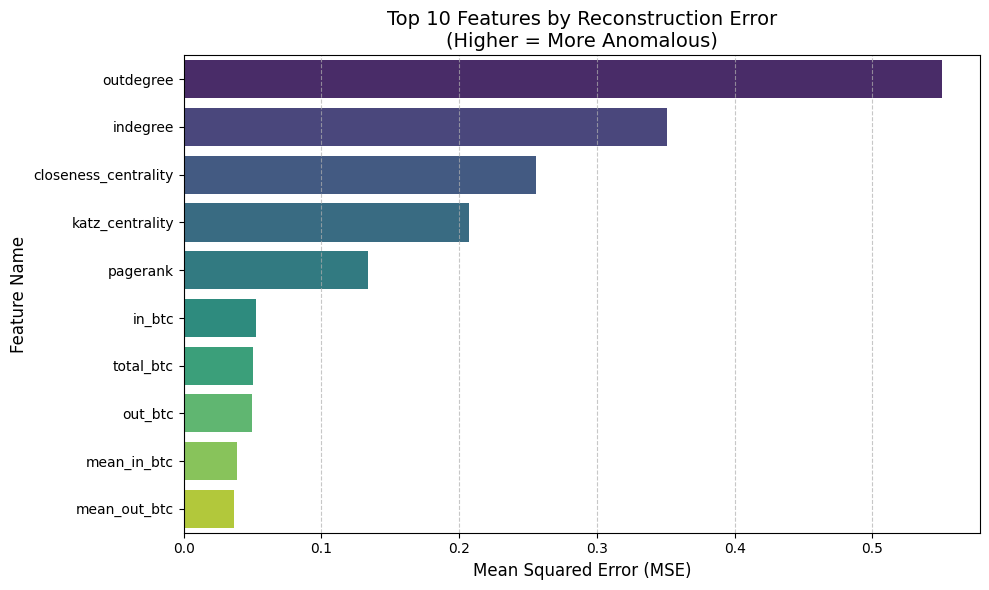

VGAE

--- Top 10 Feature Contributions (Reconstruction Error) ---
                 Feature  Recon_Error
1              outdegree     0.765604
9   closeness_centrality     0.756967
0               indegree     0.401024
10       katz_centrality     0.257403
7               pagerank     0.108988
2                 in_btc     0.098401
4              total_btc     0.097345
3                out_btc     0.092413
5            mean_in_btc     0.080956
6           mean_out_btc     0.066321


C:\Users\HQ\AppData\Local\Temp\ipykernel_38668\9561394.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Recon_Error', y='Feature', data=df_top10, palette='viridis')


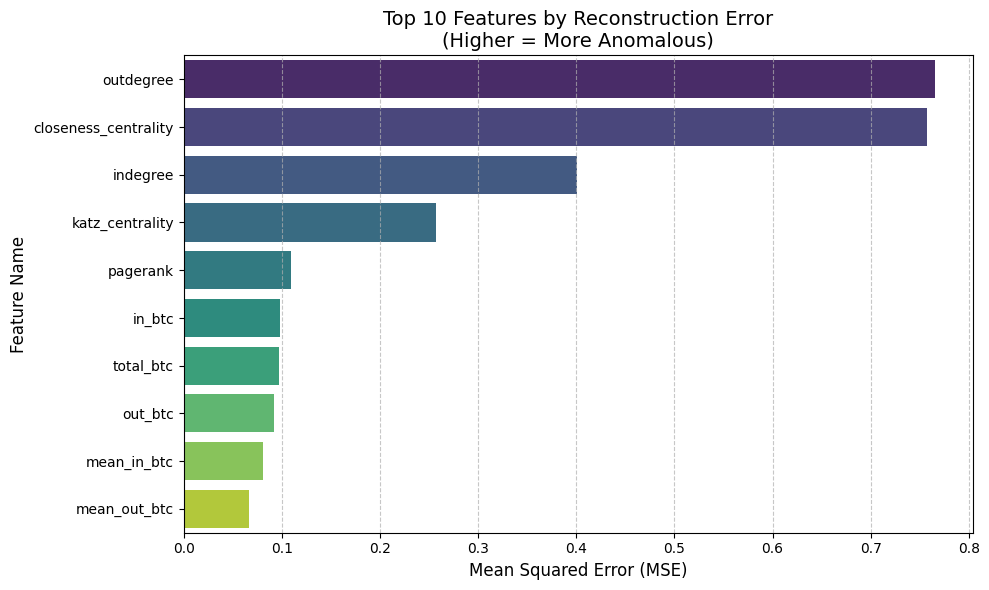

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np

def get_reconstruction_contribution(model, data, feature_names):
    """
    Analyzes which features contribute most to the reconstruction error.
    High Error = The feature is 'Anomalous'.
    Displays the TOP 10 features in a horizontal blue bar chart.
    """
    model.eval()
    with torch.no_grad():
        # Ensure data is on the same device as the model
        device = next(model.parameters()).device
        safe_x = torch.clamp(data.x, min=-5.0, max=5.0).to(device)
        edge_index = data.edge_index.to(device)
        
        # Get reconstruction
        if hasattr(model, 'reparameterize'): # VGAE
            output = model(safe_x, edge_index)
            if isinstance(output, tuple): x_recon = output[0]
            else: x_recon = output
        else: # GAE
            output = model(safe_x, edge_index)
            if isinstance(output, tuple): x_recon = output[0]
            else: x_recon = output

        # Calculate Squared Error per feature
        error_matrix = (safe_x - x_recon)**2
        
        # Average error per feature across ALL nodes
        avg_error_per_feature = torch.mean(error_matrix, dim=0).cpu().numpy()

        # Create DataFrame
        df_err = pd.DataFrame({
            'Feature': feature_names,
            'Recon_Error': avg_error_per_feature
        })
        
        # Sort by Error (Descending)
        df_err = df_err.sort_values(by='Recon_Error', ascending=False)
        
        #  FILTER FOR TOP 10 ONLY 
        df_top10 = df_err.head(10)
        
        print("\n--- Top 10 Feature Contributions (Reconstruction Error) ---")
        print(df_top10)

        plt.figure(figsize=(10, 6))
        
        # Use color='tab:blue' for consistent blue color
        sns.barplot(x='Recon_Error', y='Feature', data=df_top10, palette='viridis')
        
        plt.title('Top 10 Features by Reconstruction Error\n(Higher = More Anomalous)', fontsize=14)
        plt.xlabel('Mean Squared Error (MSE)', fontsize=12)
        plt.ylabel('Feature Name', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        return None

print("GAE")
get_reconstruction_contribution(model_gcn_optimized, data, feature_cols)
print("VGAE")
get_reconstruction_contribution(model_vgae, data, feature_cols)